<a href="https://colab.research.google.com/github/ChelseaLiu0822/LDRPM-Loan-Default-Risk-Prediction-Model/blob/main/LDRPM_Loan_Default_Risk_Prediction_Model_Project_(datacleaningCompleted).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'home-credit-credit-risk-model-stability:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F50160%2F7921029%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240504%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240504T205423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D98a3018592b601346690c7ac0e758565053dc5fdd46fe9e7f00d96db257e8fcbb01442fe0c8f72ebc092bf7bbaba2ff9cc7f3fa5ad71b004fb9e0a1cf9395d0a5f29fad96203aa5f5c1db31f4d2b59ab80594ac1d90aa9a49c35c230089b650bde046faba050f7ea331f84bea6fa613d5d22a117b169413831dd6fbec10c8e2b6d56bc75b19480cafb453eb8e76f711e89559967f92603467008ec6fb03a113be57696cac5f5b79cd2c45faaaa737314c50a48a0ff8fd0d97116304f7f55d158f2ec6b7e7e3d45bb375e231dd8f0d0ae1bc1ef539a5462bff4c18be4a68c9b719f559323b6a4db4e35e6e5ddc4f13f144f4e64f208b6836876d6617a2ee193c2'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 3375704785 bytes downloaded
Downloaded and uncompressed: home-credit-credit-risk-model-stability
Data source import complete.


In [4]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 17.7 MB/s eta 0:00:00


In [5]:
import os
import gc
from glob import glob
from pathlib import Path
from datetime import datetime

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.base import BaseEstimator, ClassifierMixin

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import GroupKFold

import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import IsolationForest

### Pre-Fitted Voting Model

In [6]:
class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators

    def fit(self, X, y=None):
        return self

    def predict(self, X):
        y_preds = [estimator.predict(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

    def predict_proba(self, X):
        y_preds = [estimator.predict_proba(X) for estimator in self.estimators]
        return np.mean(y_preds, axis=0)

### Pipeline

In [7]:
class Pipeline:
    @staticmethod
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int32))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.Utf8))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))

        return df

    @staticmethod
    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))
                df = df.with_columns(pl.col(col).dt.total_days())
                df = df.with_columns(pl.col(col).cast(pl.Float32))

        df = df.drop("date_decision", "MONTH")

        return df

    @staticmethod
    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()

                if isnull > 0.95:
                    df = df.drop(col)

        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.Utf8):
                freq = df[col].n_unique()

                if (freq == 1) | (freq > 200):
                    df = df.drop(col)

        return df

### Automatic Aggregation

In [8]:
class Aggregator:
    @staticmethod
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]

        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]

        return expr_max

    @staticmethod
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

### File I/O

In [9]:
def read_file(path, depth=None):
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)

    if depth in [1, 2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

    return df

def read_files(regex_path, depth=None):
    chunks = []
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)

        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))

        chunks.append(df)

    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])

    return df

### Feature Engineering

In [10]:
def feature_eng(df_base, depth_0, depth_1, depth_2):
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )

    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")

    df_base = df_base.pipe(Pipeline.handle_dates)

    return df_base

In [11]:
def to_pandas(df_data, cat_cols=None):
    df_data = df_data.to_pandas()

    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)

    df_data[cat_cols] = df_data[cat_cols].astype("category")

    return df_data, cat_cols

### Configuration

In [12]:
ROOT            = Path("/kaggle/input/home-credit-credit-risk-model-stability")
TRAIN_DIR       = ROOT / "parquet_files" / "train"
TEST_DIR        = ROOT / "parquet_files" / "test"

### Train Files Read & Feature Engineering

In [13]:
data_store = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

According to function, we processed these original forms.

First, we used Pre-Fitted Voting Model to take the average of the predicted probabilities for each base learner;

Used Pipeline to conduct data preprocessing, such as setting data type, setting date and filtering characteristic parameters;

Used Aggregator to aggregate tables according their meaning and usage;

Used read_file to read and combine files;

Used feature_eng to conduct simple feature engineering.

Used to pandas to trun Modin DataFrame into Pandas DataFrame.


In [14]:
df_train = feature_eng(**data_store)

print("train data shape:\t", df_train.shape)

train data shape:	 (1526659, 472)


Then, we get a df_train dataframe.

### Test Files Read & Feature Engineering

In [15]:
data_store = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}

In [16]:
df_test = feature_eng(**data_store)

print("test data shape:\t", df_test.shape)

test data shape:	 (10, 471)


Get a test dataset: df_test.

### Feature Elimination

In [17]:
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape:\t", df_train.shape)
print("test data shape:\t", df_test.shape)

train data shape:	 (1526659, 361)
test data shape:	 (10, 360)


### Pandas Conversion

In [18]:
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)

In [19]:
df_train1=df_train.copy()
df_test_1=df_test.copy()

### Outlier detection

In [21]:
no_number = ['case_id', 'WEEK_NUM', 'target', 'month_decision', 'weekday_decision']  # mainly detect the variables

float_columns = df_train.select_dtypes(include=['float64']).columns.tolist()    # we used isoluation forest to conduct outlier detection

float_columns = [col for col in float_columns if col not in no_number]

df_train[float_columns] = df_train[float_columns].fillna(df_train[float_columns].mean())

isolation_forest = IsolationForest(random_state=88)

outlier_predictions = isolation_forest.fit_predict(df_train[float_columns])

outlier_indices = np.where(outlier_predictions == -1)[0]    # if value = -1, then it is the outlier

df_train = df_train.drop(df_train.index[outlier_indices])

NameError: name 'IsolationForest' is not defined

### Garbage Collection

In [22]:
del data_store

gc.collect()

46

### EDA

First, let's see the distribution of the target variable.

From the table we can see, the target variable is unbalanced.

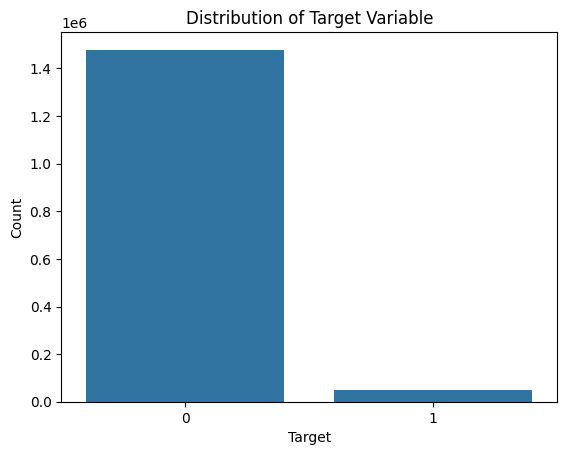

In [23]:

target_counts = df_train['target'].value_counts()


sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

In [24]:
len(df_train1[df_train1['target'] == 0])

1478665

In [25]:
len(df_train1[df_train1['target'] == 1])

47994

Next, we oversample and undersample at the same time, so that the target variable distribution is balanced

In [26]:

num_target_0_removed = int(len(df_train[df_train['target'] == 0]) * 3 / 4)

num_target_1_copied = len(df_train[df_train['target'] == 1]) * 7

df_target_1_copied = df_train[df_train['target'] == 1].copy()
for _ in range(6):
    df_train = pd.concat([df_train, df_target_1_copied], ignore_index=True)

df_train = df_train.drop(df_train[df_train['target'] == 0].sample(n=num_target_0_removed).index)

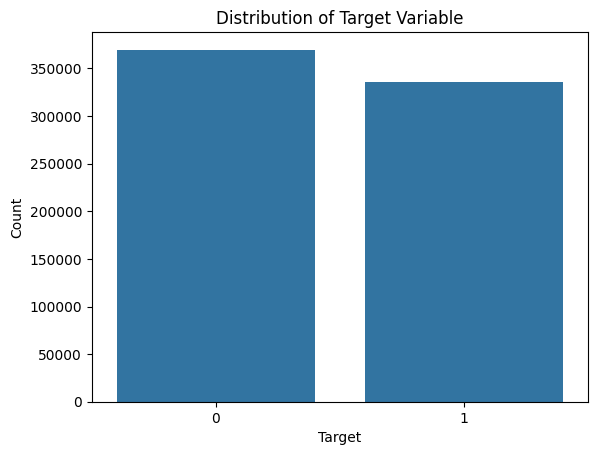

In [27]:
target_counts = df_train['target'].value_counts()

sns.barplot(x=target_counts.index, y=target_counts.values)
plt.title('Distribution of Target Variable')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

Now, the target variable distribution is balanced

Then, we can use plot to see the trend between "WEEK_NUM" and "target".

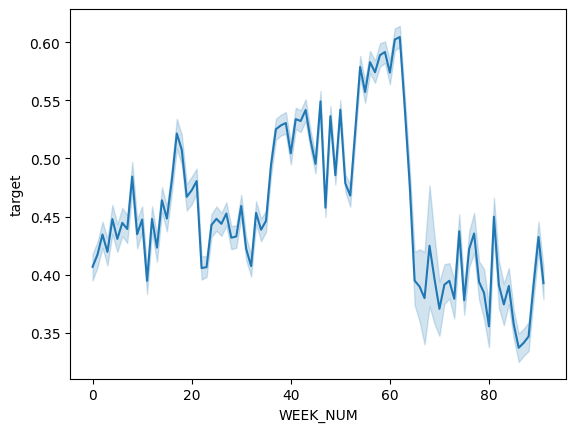

In [28]:
sns.lineplot(
    data=df_train,
    x="WEEK_NUM",
    y="target",
)
plt.show()

Then, we can use the plot to the difference of target type distribution in different time dimensions

NameError: name 'PALETTE' is not defined

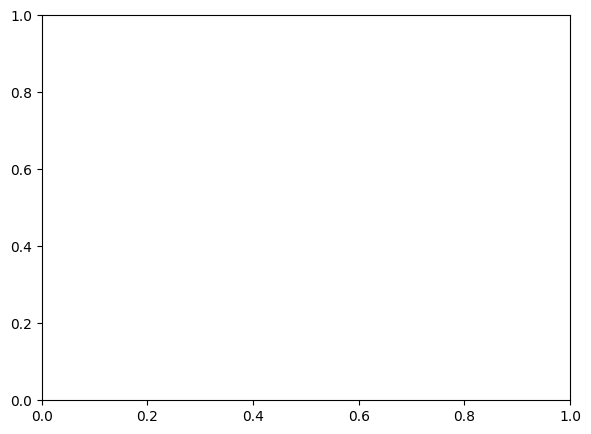

In [29]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=df_train, x='month_decision', bins=30, multiple="stack", kde=False, hue='target',
             palette=PALETTE)
plt.title('Month Distribution')
plt.xlabel('Month')
plt.ylabel('Frequency')


plt.subplot(1, 2, 2)
sns.histplot(data=df_train, x='weekday_decision', bins=30, multiple="stack", kde=False, hue='target',
             palette=PALETTE)
plt.title('Weekday Distribution')
plt.xlabel('Weekday')
plt.ylabel('Frequency')

plt.tight_layout()

plt.show()

See the distribution of null value

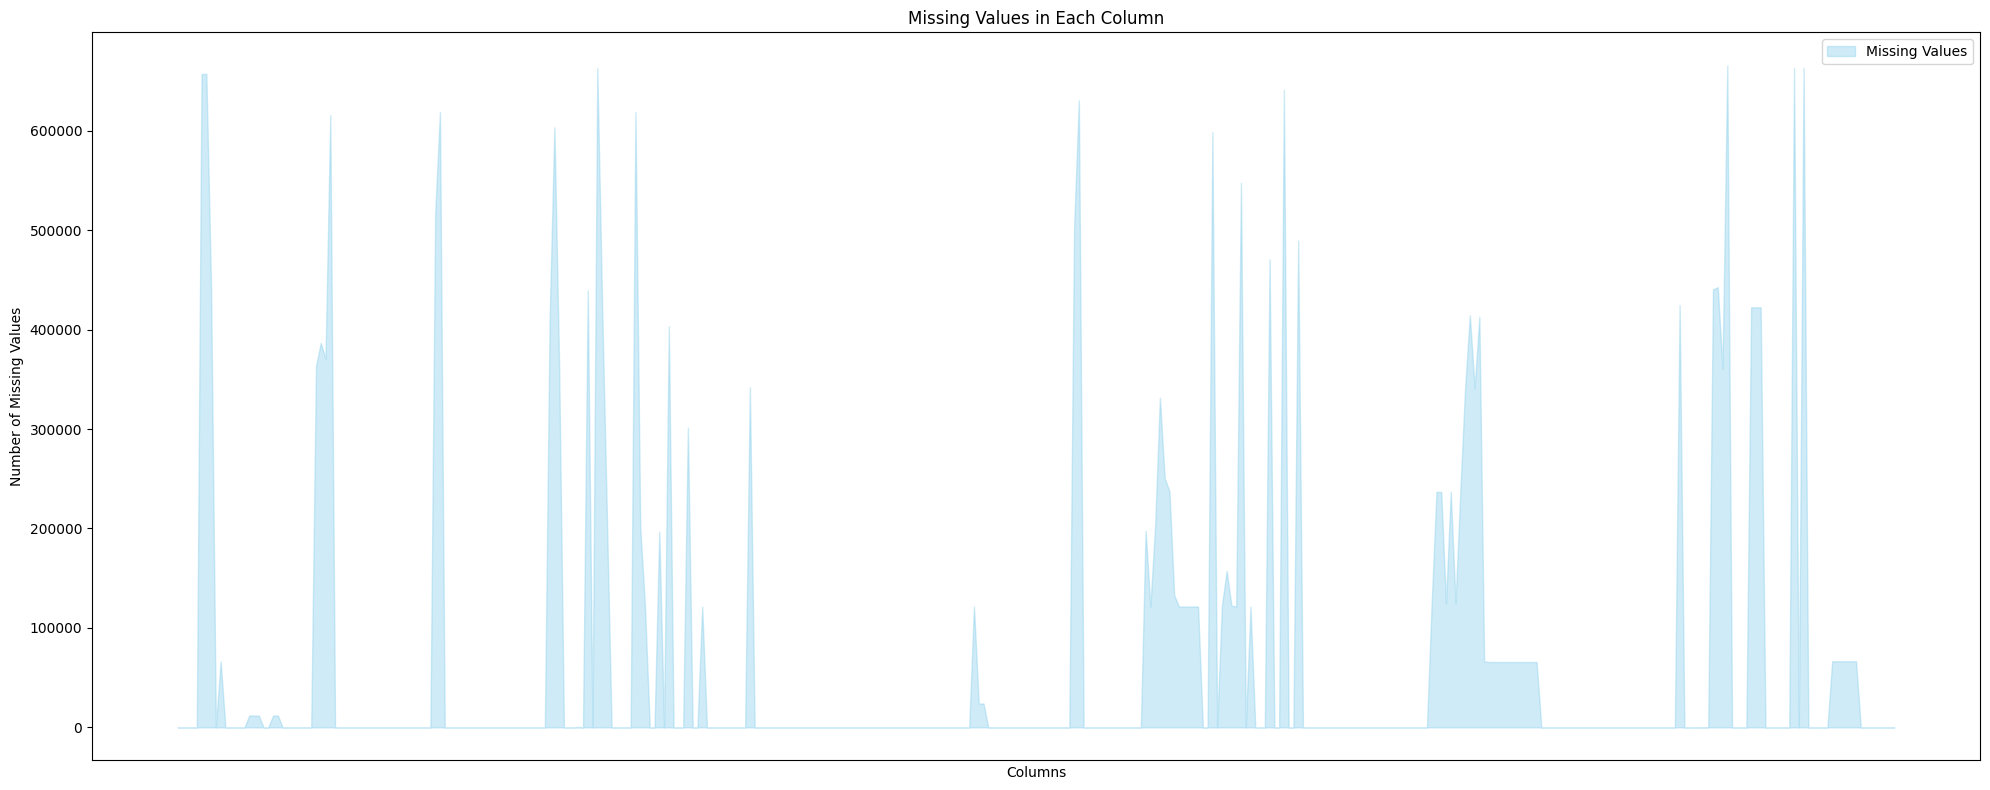

In [29]:
missing_values = df_train.isnull().sum()

plt.figure(figsize=(20, 8))
plt.fill_between(missing_values.index, missing_values.values, color='skyblue', alpha=0.4, label='Missing Values')

plt.title('Missing Values in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')

plt.legend()

plt.xticks([])

plt.tight_layout()
plt.show()

Look at the correlation between the variables

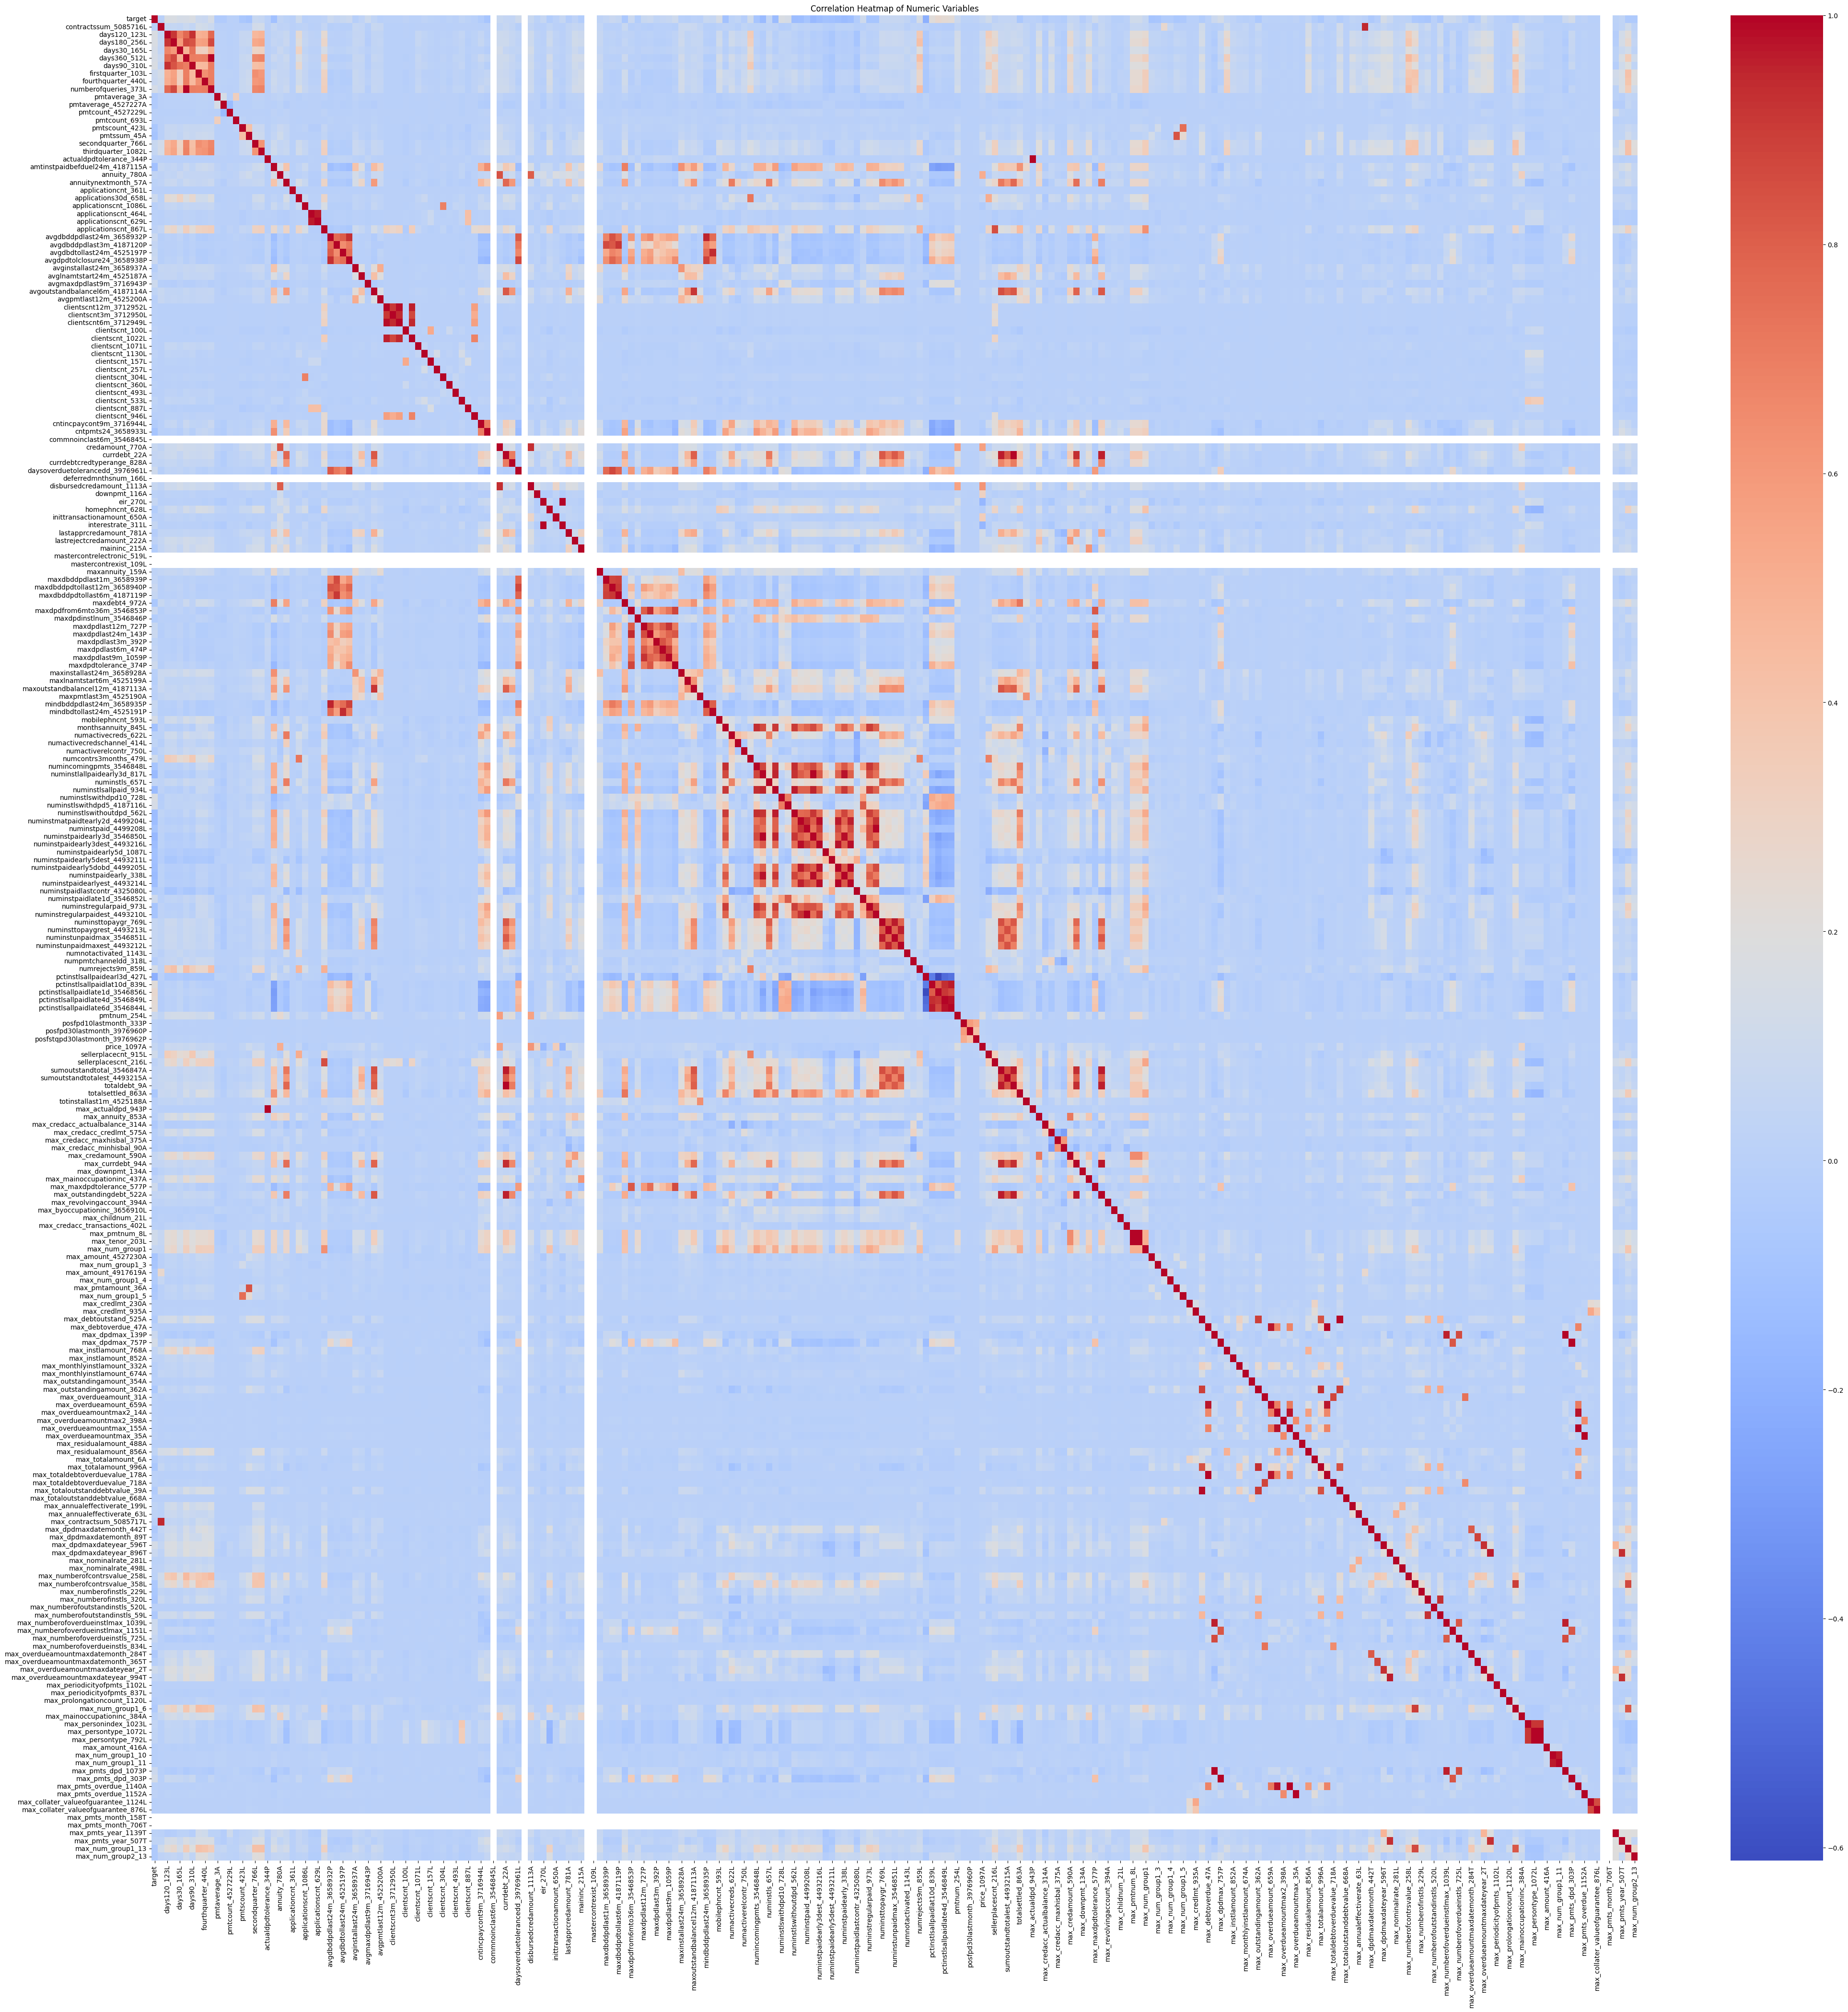

In [30]:
numeric_columns = df_train.select_dtypes(include=['int64', 'float64']).columns

df_numeric = df_train[numeric_columns]


corr_matrix = df_numeric.corr()

plt.figure(figsize=(50, 50))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numeric Variables')
plt.show()

### Training

LightGBM Model

In [51]:
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "auc",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbose": -1,
    "random_state": 42,
    "device": "cpu",
}

fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model_lgb = lgb.LGBMClassifier(**params)
    model_lgb.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric='auc',
        callbacks=[lgb.log_evaluation(100), lgb.early_stopping(100)]
    )

    fitted_models.append(model_lgb)

model_LGB = VotingModel(fitted_models)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.836563
[200]	valid_0's auc: 0.847357
[300]	valid_0's auc: 0.851557
[400]	valid_0's auc: 0.85347
[500]	valid_0's auc: 0.85404
[600]	valid_0's auc: 0.854335
[700]	valid_0's auc: 0.854359
Early stopping, best iteration is:
[668]	valid_0's auc: 0.854464
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.841079
[200]	valid_0's auc: 0.852621
[300]	valid_0's auc: 0.856773
[400]	valid_0's auc: 0.858597
[500]	valid_0's auc: 0.8594
[600]	valid_0's auc: 0.859754
[700]	valid_0's auc: 0.859758
[800]	valid_0's auc: 0.859826
[900]	valid_0's auc: 0.859763
Early stopping, best iteration is:
[808]	valid_0's auc: 0.859901
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.832135
[200]	valid_0's auc: 0.842026
[300]	valid_0's auc: 0.845705
[400]	valid_0's auc: 0.847377
[500]	valid_0's auc: 0.847958
[600]	valid_0's auc: 0.848305
[700]	valid_0's auc: 0.84842

### Prediction

In [66]:
#LightGBM prediction
X_test_lgb = df_test.drop(columns=["WEEK_NUM"])
X_test_lgb = X_test_lgb.set_index("case_id")

y_pred_lgb = pd.Series(model_LGB.predict_proba(X_test_lgb)[:, 1], index=X_test_lgb.index)
print(y_pred_lgb.head())

case_id
57543    0.197997
57549    0.715808
57551    0.077719
57552    0.398433
57569    0.527334
dtype: float64


### Result


In [54]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred_lgb

In [55]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.197997
57549,0.715808
57551,0.077719
57552,0.398433
57569,0.527334


In [ ]:
df_subm.to_csv("submission_LGB.csv")


# Training with 2 different Models

Run this section seprately with LightGB model section since I am using two different models here

###XGBoost Model

In [56]:
#XGBoost
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
weeks = df_train["WEEK_NUM"]

cv = StratifiedGroupKFold(n_splits=5, shuffle=False)

params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "max_depth": 6,
    "learning_rate": 0.05,
    "n_estimators": 1000,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "verbosity": 0,
    "random_state": 42,
    "tree_method": "gpu_hist",
    "enable_categorical": True , # Enable experimental categorical feature support
}

fitted_models = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y, groups=weeks)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model_xg = xgb.XGBClassifier(**params)
    model_xg.fit(
        X_train, y_train,
        eval_set=[(X_valid, y_valid)],
        verbose=100
    )

    fitted_models.append(model_xg)
    print(f"Completed training fold {fold+1}/{cv.n_splits}")

# Function to compute average predictions from multiple models
def average_predict(models, X):
    preds = [model_xg.predict_proba(X)[:, 1] for model_xg in models]
    return np.mean(preds, axis=0)

# Example of creating a voting classifier from the fitted models (not needed if using average_predict)
model_XG = VotingClassifier(estimators=[(f"model_{i}", m) for i, m in enumerate(fitted_models)], voting='soft')




[0]	validation_0-auc:0.74375
[100]	validation_0-auc:0.83741
[200]	validation_0-auc:0.84656
[300]	validation_0-auc:0.85003
[400]	validation_0-auc:0.85163
[500]	validation_0-auc:0.85241
[600]	validation_0-auc:0.85295
[700]	validation_0-auc:0.85285
[800]	validation_0-auc:0.85284
[900]	validation_0-auc:0.85274
[999]	validation_0-auc:0.85243
Completed training fold 1/5
[0]	validation_0-auc:0.75014
[100]	validation_0-auc:0.84235
[200]	validation_0-auc:0.85143
[300]	validation_0-auc:0.85483
[400]	validation_0-auc:0.85652
[500]	validation_0-auc:0.85730
[600]	validation_0-auc:0.85783
[700]	validation_0-auc:0.85800
[800]	validation_0-auc:0.85809
[900]	validation_0-auc:0.85807
[999]	validation_0-auc:0.85787
Completed training fold 2/5
[0]	validation_0-auc:0.73554
[100]	validation_0-auc:0.83334
[200]	validation_0-auc:0.84183
[300]	validation_0-auc:0.84448
[400]	validation_0-auc:0.84592
[500]	validation_0-auc:0.84645
[600]	validation_0-auc:0.84708
[700]	validation_0-auc:0.84740
[800]	validation_0-a

XGBoost Prediection and Results

In [65]:
# Preparing X_test
X_test_xg = df_test.drop(columns=["WEEK_NUM"])
X_test_xg = X_test_xg.set_index("case_id")

# Collecting predictions from each model
model_predictions = [model_xg.predict_proba(X_test_xg)[:, 1] for model_xg in fitted_models]

# Calculating the average of the probabilities across all models
average_probabilities = np.mean(model_predictions, axis=0)

# Creating a pandas Series to store the final averaged probabilities
y_pred_xg = pd.Series(average_probabilities, index=X_test_xg.index)

print(y_pred_xg.head())


case_id
57543    0.000095
57549    0.000256
57551    0.000058
57552    0.000070
57569    0.001251
dtype: float32


In [62]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred_xg


In [63]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.000095
57549,0.000256
57551,0.000058
57552,0.000070
57569,0.001251


In [42]:
df_subm.to_csv("submission_XGBoost.csv")

###CatBoost Model

In [67]:
#CatBoost Model
X = df_train.drop(columns=["target", "case_id", "WEEK_NUM"])
y = df_train["target"]
groups = df_train["WEEK_NUM"]

# Identify categorical features
cat_features = [col for col in X.columns if X[col].dtype.name == 'category']

# Fill NaN values in categorical columns with a specific category 'missing'
for col in cat_features:
    X[col] = X[col].astype(str).fillna('missing')

# CatBoost parameters
params = {
    "iterations": 1000,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": 'Logloss',
    "eval_metric": 'AUC',
    "random_seed": 42,
    "verbose": 100,
    "task_type": "GPU",
    "early_stopping_rounds": 50,  # More aggressive early stopping
    "border_count": 128  # Experiment this to balance accuracy vs speed further
}

# Model training setup
fitted_models = []
cv = GroupKFold(n_splits=5)

for idx_train, idx_valid in cv.split(X, y, groups=groups):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    # Use Pool to manage data and specify categorical features
    train_pool = Pool(X_train, y_train, cat_features=cat_features)
    valid_pool = Pool(X_valid, y_valid, cat_features=cat_features)

    model_cat = CatBoostClassifier(**params)
    model_cat.fit(
        train_pool,
        eval_set=valid_pool,
        use_best_model=True
    )

    fitted_models.append(model_cat)

# Combining models (simple averaging method for demonstration)
def average_predict(models, X):
    preds_cat = [model_cat.predict_proba(X)[:, 1] for model_cat in models]
    return np.mean(preds_cat, axis=0)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7222059	best: 0.7222059 (0)	total: 144ms	remaining: 2m 24s
100:	test: 0.8273262	best: 0.8273262 (100)	total: 14s	remaining: 2m 4s
200:	test: 0.8379468	best: 0.8379468 (200)	total: 27.4s	remaining: 1m 49s
300:	test: 0.8431418	best: 0.8431418 (300)	total: 40.9s	remaining: 1m 34s
400:	test: 0.8465083	best: 0.8465083 (400)	total: 54.2s	remaining: 1m 20s
500:	test: 0.8483952	best: 0.8483952 (500)	total: 1m 7s	remaining: 1m 7s
600:	test: 0.8494063	best: 0.8494287 (598)	total: 1m 20s	remaining: 53.5s
700:	test: 0.8502914	best: 0.8503091 (694)	total: 1m 33s	remaining: 40s
800:	test: 0.8509885	best: 0.8509885 (800)	total: 1m 46s	remaining: 26.6s
900:	test: 0.8515723	best: 0.8515723 (900)	total: 2m	remaining: 13.2s
999:	test: 0.8519524	best: 0.8520488 (996)	total: 2m 13s	remaining: 0us
bestTest = 0.8520487547
bestIteration = 996
Shrink model to first 997 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7263792	best: 0.7263792 (0)	total: 149ms	remaining: 2m 28s
100:	test: 0.8267277	best: 0.8267277 (100)	total: 13.9s	remaining: 2m 3s
200:	test: 0.8363754	best: 0.8363754 (200)	total: 27.3s	remaining: 1m 48s
300:	test: 0.8412176	best: 0.8412176 (300)	total: 40.7s	remaining: 1m 34s
400:	test: 0.8443563	best: 0.8443563 (400)	total: 53.9s	remaining: 1m 20s
500:	test: 0.8461098	best: 0.8461098 (500)	total: 1m 7s	remaining: 1m 6s
600:	test: 0.8474051	best: 0.8474051 (600)	total: 1m 20s	remaining: 53.3s
700:	test: 0.8481709	best: 0.8481709 (700)	total: 1m 33s	remaining: 39.9s
800:	test: 0.8485598	best: 0.8485598 (800)	total: 1m 46s	remaining: 26.5s
900:	test: 0.8492575	best: 0.8492647 (899)	total: 1m 59s	remaining: 13.2s
999:	test: 0.8495094	best: 0.8495300 (994)	total: 2m 13s	remaining: 0us
bestTest = 0.8495300412
bestIteration = 994
Shrink model to first 995 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7318941	best: 0.7318941 (0)	total: 142ms	remaining: 2m 22s
100:	test: 0.8359505	best: 0.8359505 (100)	total: 13.8s	remaining: 2m 3s
200:	test: 0.8470823	best: 0.8470823 (200)	total: 27.3s	remaining: 1m 48s
300:	test: 0.8523566	best: 0.8523566 (300)	total: 40.6s	remaining: 1m 34s
400:	test: 0.8552348	best: 0.8552348 (400)	total: 54s	remaining: 1m 20s
500:	test: 0.8567780	best: 0.8567780 (500)	total: 1m 7s	remaining: 1m 6s
600:	test: 0.8579961	best: 0.8580019 (599)	total: 1m 20s	remaining: 53.3s
700:	test: 0.8586071	best: 0.8586765 (695)	total: 1m 33s	remaining: 39.8s
800:	test: 0.8591697	best: 0.8592396 (792)	total: 1m 46s	remaining: 26.5s
900:	test: 0.8595150	best: 0.8595251 (891)	total: 1m 59s	remaining: 13.2s
999:	test: 0.8597513	best: 0.8597744 (983)	total: 2m 12s	remaining: 0us
bestTest = 0.8597743511
bestIteration = 983
Shrink model to first 984 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7226453	best: 0.7226453 (0)	total: 148ms	remaining: 2m 27s
100:	test: 0.8248247	best: 0.8248247 (100)	total: 13.9s	remaining: 2m 3s
200:	test: 0.8358527	best: 0.8358527 (200)	total: 27.4s	remaining: 1m 49s
300:	test: 0.8409054	best: 0.8409054 (300)	total: 40.8s	remaining: 1m 34s
400:	test: 0.8439716	best: 0.8439716 (400)	total: 54.1s	remaining: 1m 20s
500:	test: 0.8458528	best: 0.8458528 (500)	total: 1m 7s	remaining: 1m 7s
600:	test: 0.8467782	best: 0.8467782 (600)	total: 1m 20s	remaining: 53.4s
700:	test: 0.8477079	best: 0.8477201 (698)	total: 1m 33s	remaining: 39.9s
800:	test: 0.8484130	best: 0.8484130 (800)	total: 1m 46s	remaining: 26.5s
900:	test: 0.8486540	best: 0.8487320 (894)	total: 2m	remaining: 13.2s
bestTest = 0.8488460183
bestIteration = 932
Shrink model to first 933 iterations.


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7237954	best: 0.7237954 (0)	total: 146ms	remaining: 2m 26s
100:	test: 0.8287345	best: 0.8287345 (100)	total: 13.9s	remaining: 2m 3s
200:	test: 0.8391664	best: 0.8391664 (200)	total: 27.3s	remaining: 1m 48s
300:	test: 0.8443557	best: 0.8443557 (300)	total: 40.7s	remaining: 1m 34s
400:	test: 0.8476077	best: 0.8476077 (400)	total: 53.9s	remaining: 1m 20s
500:	test: 0.8491677	best: 0.8491746 (499)	total: 1m 7s	remaining: 1m 6s
600:	test: 0.8504176	best: 0.8504269 (599)	total: 1m 20s	remaining: 53.3s
700:	test: 0.8511236	best: 0.8511243 (698)	total: 1m 33s	remaining: 39.8s
800:	test: 0.8520136	best: 0.8520136 (800)	total: 1m 46s	remaining: 26.5s
900:	test: 0.8522424	best: 0.8522639 (873)	total: 1m 59s	remaining: 13.2s
999:	test: 0.8524935	best: 0.8525016 (997)	total: 2m 12s	remaining: 0us
bestTest = 0.8525015712
bestIteration = 997
Shrink model to first 998 iterations.


CatBoost Prediction and results

In [69]:
# Fill NaN values in categorical columns with 'missing'
# Need fill NaN values here, since they are not automatically handled by CatBoost when making predictions
X_test[cat_features] = X_test[cat_features].astype(str).fillna('missing')

# Create a Pool object for the test set, ensuring consistency with training
test_pool = Pool(X_test, cat_features=cat_features)

# Try predicting again
y_pred_cat = pd.Series(model_cat.predict_proba(test_pool)[:, 1], index=X_test.index)
print(y_pred_cat.head())



case_id
57543    0.108481
57549    0.610698
57551    0.034810
57552    0.537382
57569    0.570293
dtype: float64


In [71]:
df_subm = pd.read_csv(ROOT / "sample_submission.csv")
df_subm = df_subm.set_index("case_id")

df_subm["score"] = y_pred_cat

In [72]:
print("Check null: ", df_subm["score"].isnull().any())

df_subm.head()

Check null:  False


,score
case_id,
57543,0.108481
57549,0.610698
57551,0.034810
57552,0.537382
57569,0.570293


In [ ]:
df_subm.to_csv("submission_CatBoost.csv")